<a href="https://colab.research.google.com/github/TALeonard/19ma573thomasleonard/blob/master/src/hw11_crr_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import modules and import our options class.

In [0]:
#!git clone https://github.com/TALeonard/18ma573pub.git #Only run once!

Cloning into '18ma573pub'...
remote: Enumerating objects: 763, done.
remote: Total 763 (delta 0), reused 0 (delta 0), pack-reused 763
Receiving objects: 100% (763/763), 2.47 MiB | 5.81 MiB/s, done.
Resolving deltas: 100% (449/449), done.


In [0]:
cd /content/18ma573pub/src/

/content/18ma573pub/src


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from contract_v01 import VanillaOption
from sde_1d_v01 import Sde_1d, Gbm_1d

We were given:

* Call (Otype = 1)
* Matuirty T = 1
* Strike K = 100
* Spot $S_{0}$ = 100
* Volatility $\sigma$ = 0.2
* Interest rate r = 0.05

First, directly compute the BSM call value.

In [0]:
otype = 1
T = 1
K = 100
s0 = 100
sigma = 0.2
r = 0.05

gbm_true = Gbm_1d(init_state=s0, drift_ratio = r, vol_ratio = sigma)
call_price = gbm_true.bsm_price(VanillaOption(otype,K,T))

print("True BSM Call Value is " + str(call_price))

True BSM Call Value is 10.450583572185565


The CRR(N) model is equal to FTCS with a grid

$$\Delta x = \sigma \sqrt{\Delta t}, \Delta t = T/N$$

With $N$ steps on $[0, T]$. We want the value of CRR(N = 2000).

We define, based on lecture notes, that

$$u_{j}^{n-1} = pu_{j+1}^{n} + (1-p)u_{j-1}^{n}$$

with

$$p  =\frac{1 + \hat r \sqrt{\Delta t}}{2\sigma}$$

and

$$\hat r = r - \frac{1}{2}\sigma^{2}$$

In [0]:
def CRR(r,sigma,S,T,N):
  #Define deltas.
  dt = T / N
  dx = sigma * np.sqrt(dt)
  r_hat = r - 0.5*(sigma**2)
  p=(sigma + (r_hat*np.sqrt(dt)))/(2*sigma)
  
  u = np.exp(dx)
  d = 1/(u)
  
  V_prev = np.zeros(N+1)
  V_current = np.zeros(N+1)
    
  for j in range(0,N+1):
      V_prev[j] = max(S*(u**j)*(d**(N-j))-K,0)
    
  i=N
  while i>0:        
      for j in range(0,i):
          V_current[j] = np.exp(-r*dt)*((1-p)*V_prev[j]+p*V_prev[j+1])
      i=i-1
      V_prev = V_current
        
  return V_prev[0]

In [0]:
o1 = CRR(r,sigma,s0,T,2000)
print("CRR(N = 2000) is " + str(o1))

My CRR is 10.44955246588764
Other CRR is 10.449583775457942


If this is right then I simply run a couple of for loops which populate based on CRR(10+20k) and CRR(10 + 25k) for $k \in range(50)$. Ask professor tomorrow during his OH.

In [0]:
CRR_20 = np.zeros(50)
N_20_vec = np.zeros(50)
CRR_25 = np.zeros(50)
N_25_vec = np.zeros(50)
BSM_price = np.zeros(50)

for k in range(50):
  CRR_20[k] = CRR(r, sigma, s0, T, 10 + (20*k))
  N_20_vec[k] = 10 + (20*k)
  CRR_25[k] = CRR(r, sigma, s0, T, 10 + (25*k))
  N_25_vec[k] = 10 + (25*k)
  BSM_price[k] = call_price

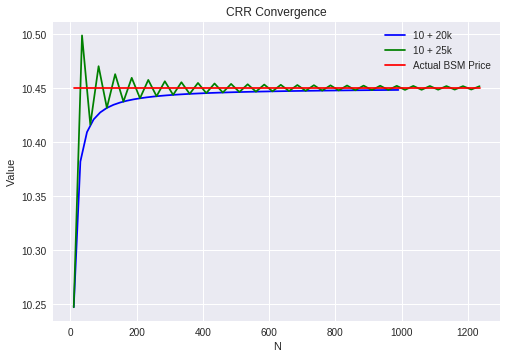

In [0]:
plt.figure()
plt.plot(N_20_vec,CRR_20,'b',N_25_vec,CRR_25,'g',N_25_vec,BSM_price,'r')
plt.xlabel("N")
plt.ylabel("Value")
plt.title("CRR Convergence")
plt.legend(["10 + 20k", "10 + 25k", "Actual BSM Price"])

The 10+20k vector converges very smoothly, but the 10+25k vector converges in a decreasing amplitude, zigzagging back and forth across the line representing the true BSM price but still approaching it as N increases.